# About this notebook  

TBD...

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True

# Data Loading

In [2]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
os.listdir("../input/cassava-leaf-disease-classification")

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'train_tfrecords',
 'test_tfrecords',
 'test_images',
 'train_images',
 'train.csv']

In [4]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")
# train = pd.read_csv("../input/cassava-leaf-disease-merged/oversample-0124.csv")  # label 0124 x3
test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")
display(train.head())
display(test.head())
display(label_map)

,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,1,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/home/ubuntu/work/pytorch/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

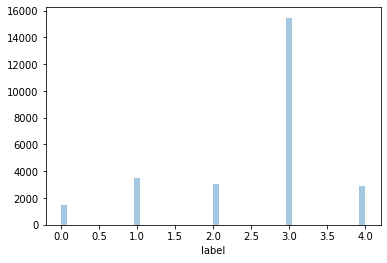

In [5]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = False
    print_freq = 100
    num_workers = 4
    model_name = (
        "tf_efficientnet_b4_ns"  # resnext50_32x4d, tf_efficientnet_b3_ns, tf_efficientnet_b4_ns, vit_base_patch16_384
    )
    batch_size = 8  # resnext50_32x4d: 14-30, tf_efficientnet_b3_ns:10-22, tf_efficientnet_b4_ns: 8-16
    gradient_accumulation_steps = 4
    size = 384 if model_name.startswith("vit_base_") else 512  # 512 if ON_KAGGLE else 384
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.05
    scheduler = "CosineAnnealingWarmupRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    scheduler_batch_update = True
    epochs = 10
    # factor = 0.2  # ReduceLROnPlateau
    # patience = 4  # ReduceLROnPlateau
    # eps = 1e-6  # ReduceLROnPlateau
    # T_max = 10  # CosineAnnealingLR
    T_0 = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs
    )  # CosineAnnealingWarmRestarts
    first_cycle_steps = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs
    )  # CosineAnnealingWarmupRestarts for batch update
    warmup_steps = first_cycle_steps // 10  # CosineAnnealingWarmupRestarts
    gamma = 0.8  # CosineAnnealingWarmupRestarts
    lr = 2e-4
    min_lr = 2e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    seed = 789
    target_size = 5
    target_col = "label"
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/pytorchcosineannealingwithwarmup")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [10]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         299
      1         695
      2         604
      3        3092
      4         578
1     0         299
      1         695
      2         604
      3        3092
      4         578
2     0         298
      1         695
      2         603
      3        3093
      4         578
3     0         298
      1         695
      2         603
      3        3093
      4         578
4     0         298
      1         696
      2         603
      3        3092
      4         578
dtype: int64


# Dataset

In [11]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).long()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

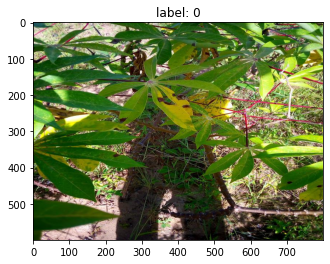

In [12]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transforms

In [13]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

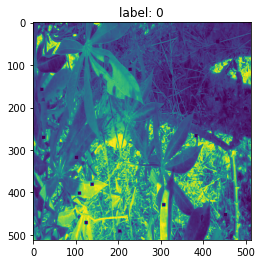

In [14]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# CutMix / FMix


In [15]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets


def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    # mask =torch.tensor(mask, device=device).float()
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, shuffled_targets, lam)

    return (x1 + x2), targets

# MODEL

In [16]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if model_name == "resnext50_32x4d":
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, CFG.target_size)

        elif model_name.startswith("tf_efficientnet"):
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG.target_size)

        elif model_name.startswith("vit_base_"):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

    elif CFG.model_name.startswith("resnext50_32x4d") and False:
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2}: {type(child2)} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                if isinstance(child2, nn.modules.container.Sequential):
                    for child3 in child2.children():
                        for child4 in child3.children():
                            if isinstance(child4, nn.BatchNorm2d):
                                # print(child4)
                                for param in child4.parameters():
                                    param.requires_grad = False
                                    # print(param.requires_grad)

In [18]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[-0.1202, -0.0398, -0.1717,  0.1486, -0.0151],
        [-0.1631, -0.2072, -0.2271,  0.1621, -0.0672],
        [-0.1093,  0.0446, -0.0454,  0.0633, -0.0005],
        [-0.0291,  0.0818,  0.0740,  0.0045,  0.0347]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [19]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

# Helper functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, scheduler_batch_update=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # CutMix, FMix
        if epoch >= CFG.epochs - 1:
            mix_decision = 0.5  # Disable CutMix, FMix for final epoch
        else:
            mix_decision = np.random.rand()

        if mix_decision < 0.25:
            images, labels = cutmix(images, labels, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(images, labels, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size))

        y_preds = model(images.float())

        if mix_decision < 0.50:
            loss = criterion(y_preds, labels[0]) * labels[2] + criterion(y_preds, labels[1]) * (1.0 - labels[2])
        else:
            loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if CFG.scheduler_batch_update:
                scheduler.step()

            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f} "
                "LR: {lr:.6f}  ".format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.first_cycle_steps,
                cycle_mult=1.0,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=CFG.warmup_steps,
                gamma=CFG.gamma,
            )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda"):
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        if epoch >= CFG.epochs - 1:
            avg_loss = train_fn(
                train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )
        else:
            avg_loss = train_fn(
                train_loader, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if not CFG.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

        if epoch == CFG.epochs - 1:
            LOGGER.info(f"Epoch {epoch+1} - Save final model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_final.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [23]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Epoch: [1][0/2633] Elapsed 0m 3s (remain 173m 49s) Loss: 0.5075(0.5075) Grad: 0.2163 LR: 0.000002  
Epoch: [1][100/2633] Elapsed 1m 29s (remain 37m 26s) Loss: 0.4903(0.4983) Grad: 0.2232 LR: 0.000010  
Epoch: [1][200/2633] Elapsed 2m 55s (remain 35m 20s) Loss: 0.4773(0.4914) Grad: 0.1637 LR: 0.000017  
Epoch: [1][300/2633] Elapsed 4m 20s (remain 33m 40s) Loss: 0.4265(0.4791) Grad: 0.1809 LR: 0.000025  
Epoch: [1][400/2633] Elapsed 5m 46s (remain 32m 7s) Loss: 0.3549(0.4603) Grad: 0.1465 LR: 0.000032  
Epoch: [1][500/2633] Elapsed 7m 12s (remain 30m 39s) Loss: 0.2196(0.4378) Grad: 0.1888 LR: 0.000040  
Epoch: [1][600/2633] Elapsed 8m 37s (remain 29m 10s) Loss: 0.1702(0.4174) Grad: 0.1512 LR: 0.000047  
Epoch: [1][700/2633] Elapsed 10m 3s (remain 27m 42s) Loss: 0.2741(0.4043) Grad: 0.1857 LR: 0.000055  
Epoch: [1][800/2633] Elapsed 11m 28s (remain 26m 15s) Loss: 0.2372(0.3897) Grad: 0.1721 LR: 0.000062  
Epoch: [1][900/2633] Elapsed 12m 54s (remain 24m 48s) Loss: 0.5107(0.3800) Grad: 0.1

Epoch 1 - avg_train_loss: 0.2971  avg_val_loss: 0.1331  time: 2418s
Epoch 1 - Accuracy: 0.8580106302201974
Epoch 1 - Save Best Score: 0.8580 Model


Epoch: [2][0/2633] Elapsed 0m 1s (remain 61m 0s) Loss: 0.0918(0.0918) Grad: 0.2601 LR: 0.000200  
Epoch: [2][100/2633] Elapsed 1m 26s (remain 36m 16s) Loss: 0.3207(0.2247) Grad: 0.1793 LR: 0.000200  
Epoch: [2][200/2633] Elapsed 2m 52s (remain 34m 48s) Loss: 0.3865(0.2322) Grad: 0.2529 LR: 0.000200  
Epoch: [2][300/2633] Elapsed 4m 18s (remain 33m 20s) Loss: 0.1743(0.2363) Grad: 0.1653 LR: 0.000200  
Epoch: [2][400/2633] Elapsed 5m 44s (remain 31m 55s) Loss: 0.1671(0.2360) Grad: 0.3489 LR: 0.000200  
Epoch: [2][500/2633] Elapsed 7m 9s (remain 30m 28s) Loss: 0.2006(0.2355) Grad: 0.1900 LR: 0.000200  
Epoch: [2][600/2633] Elapsed 8m 35s (remain 29m 2s) Loss: 0.3117(0.2344) Grad: 0.1240 LR: 0.000200  
Epoch: [2][700/2633] Elapsed 10m 1s (remain 27m 37s) Loss: 0.1022(0.2342) Grad: 0.2248 LR: 0.000200  
Epoch: [2][800/2633] Elapsed 11m 26s (remain 26m 11s) Loss: 0.1333(0.2313) Grad: 0.1645 LR: 0.000199  
Epoch: [2][900/2633] Elapsed 12m 52s (remain 24m 45s) Loss: 0.3206(0.2291) Grad: 0.2133

Epoch 2 - avg_train_loss: 0.2120  avg_val_loss: 0.1271  time: 2418s
Epoch 2 - Accuracy: 0.8682611996962795
Epoch 2 - Save Best Score: 0.8683 Model


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.0759(0.1271) 
Epoch: [3][0/2633] Elapsed 0m 1s (remain 61m 8s) Loss: 0.4197(0.4197) Grad: 0.3701 LR: 0.000194  
Epoch: [3][100/2633] Elapsed 1m 27s (remain 36m 22s) Loss: 0.2090(0.2083) Grad: 0.2985 LR: 0.000194  
Epoch: [3][200/2633] Elapsed 2m 52s (remain 34m 48s) Loss: 0.3419(0.2083) Grad: 0.1661 LR: 0.000193  
Epoch: [3][300/2633] Elapsed 4m 18s (remain 33m 19s) Loss: 0.1096(0.2099) Grad: 0.1479 LR: 0.000193  
Epoch: [3][400/2633] Elapsed 5m 43s (remain 31m 53s) Loss: 0.0817(0.2045) Grad: 0.1153 LR: 0.000192  
Epoch: [3][500/2633] Elapsed 7m 9s (remain 30m 27s) Loss: 0.0885(0.2033) Grad: 0.3435 LR: 0.000192  
Epoch: [3][600/2633] Elapsed 8m 35s (remain 29m 1s) Loss: 0.1045(0.1993) Grad: 0.1276 LR: 0.000191  
Epoch: [3][700/2633] Elapsed 10m 0s (remain 27m 35s) Loss: 0.0648(0.1977) Grad: 0.1422 LR: 0.000190  
Epoch: [3][800/2633] Elapsed 11m 26s (remain 26m 9s) Loss: 0.3338(0.1991) Grad: 0.3047 LR: 0.000190  
Epoch: [3][900/2633]

Epoch 3 - avg_train_loss: 0.1972  avg_val_loss: 0.1160  time: 2414s
Epoch 3 - Accuracy: 0.8716780561883067
Epoch 3 - Save Best Score: 0.8717 Model


Epoch: [4][0/2633] Elapsed 0m 1s (remain 60m 50s) Loss: 0.1430(0.1430) Grad: 0.1799 LR: 0.000177  
Epoch: [4][100/2633] Elapsed 1m 26s (remain 36m 20s) Loss: 0.3824(0.2005) Grad: 0.2088 LR: 0.000176  
Epoch: [4][200/2633] Elapsed 2m 52s (remain 34m 43s) Loss: 0.2118(0.1989) Grad: 0.2600 LR: 0.000175  
Epoch: [4][300/2633] Elapsed 4m 17s (remain 33m 14s) Loss: 0.1857(0.1972) Grad: 0.2747 LR: 0.000174  
Epoch: [4][400/2633] Elapsed 5m 42s (remain 31m 46s) Loss: 0.1157(0.1931) Grad: 0.1547 LR: 0.000173  
Epoch: [4][500/2633] Elapsed 7m 8s (remain 30m 21s) Loss: 0.2132(0.1920) Grad: 0.1559 LR: 0.000172  
Epoch: [4][600/2633] Elapsed 8m 33s (remain 28m 57s) Loss: 0.0758(0.1903) Grad: 0.1664 LR: 0.000172  
Epoch: [4][700/2633] Elapsed 9m 59s (remain 27m 32s) Loss: 0.0245(0.1918) Grad: 0.0994 LR: 0.000171  
Epoch: [4][800/2633] Elapsed 11m 24s (remain 26m 6s) Loss: 0.0902(0.1917) Grad: 0.2635 LR: 0.000170  
Epoch: [4][900/2633] Elapsed 12m 50s (remain 24m 40s) Loss: 0.0402(0.1906) Grad: 0.147

Epoch 4 - avg_train_loss: 0.1857  avg_val_loss: 0.1138  time: 2410s
Epoch 4 - Accuracy: 0.8787015945330297
Epoch 4 - Save Best Score: 0.8787 Model


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.1155(0.1138) 
Epoch: [5][0/2633] Elapsed 0m 1s (remain 64m 9s) Loss: 0.2056(0.2056) Grad: 0.4014 LR: 0.000150  
Epoch: [5][100/2633] Elapsed 1m 27s (remain 36m 34s) Loss: 0.1307(0.1857) Grad: 0.3539 LR: 0.000149  
Epoch: [5][200/2633] Elapsed 2m 53s (remain 34m 57s) Loss: 0.0378(0.1896) Grad: 0.1159 LR: 0.000148  
Epoch: [5][300/2633] Elapsed 4m 19s (remain 33m 27s) Loss: 0.1970(0.1772) Grad: 0.1104 LR: 0.000147  
Epoch: [5][400/2633] Elapsed 5m 44s (remain 32m 0s) Loss: 0.4039(0.1779) Grad: 0.1790 LR: 0.000146  
Epoch: [5][500/2633] Elapsed 7m 10s (remain 30m 32s) Loss: 0.1718(0.1802) Grad: 0.2169 LR: 0.000145  
Epoch: [5][600/2633] Elapsed 8m 36s (remain 29m 5s) Loss: 0.1971(0.1806) Grad: 0.2048 LR: 0.000144  
Epoch: [5][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.0830(0.1816) Grad: 0.2661 LR: 0.000142  
Epoch: [5][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.1705(0.1826) Grad: 0.1840 LR: 0.000141  
Epoch: [5][900/2633

Epoch 5 - avg_train_loss: 0.1804  avg_val_loss: 0.1234  time: 2420s
Epoch 5 - Accuracy: 0.8779422930903569


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1392(0.1234) 
Epoch: [6][0/2633] Elapsed 0m 1s (remain 61m 15s) Loss: 0.2547(0.2547) Grad: 0.3282 LR: 0.000118  
Epoch: [6][100/2633] Elapsed 1m 27s (remain 36m 30s) Loss: 0.1101(0.1773) Grad: 0.2767 LR: 0.000117  
Epoch: [6][200/2633] Elapsed 2m 52s (remain 34m 52s) Loss: 0.3097(0.1768) Grad: 0.2648 LR: 0.000116  
Epoch: [6][300/2633] Elapsed 4m 18s (remain 33m 24s) Loss: 0.0061(0.1719) Grad: 0.0444 LR: 0.000114  
Epoch: [6][400/2633] Elapsed 5m 44s (remain 31m 55s) Loss: 0.1441(0.1737) Grad: 0.1420 LR: 0.000113  
Epoch: [6][500/2633] Elapsed 7m 9s (remain 30m 27s) Loss: 0.2913(0.1725) Grad: 0.3794 LR: 0.000112  
Epoch: [6][600/2633] Elapsed 8m 35s (remain 29m 1s) Loss: 0.0572(0.1755) Grad: 0.1070 LR: 0.000110  
Epoch: [6][700/2633] Elapsed 10m 0s (remain 27m 35s) Loss: 0.1275(0.1764) Grad: 0.2097 LR: 0.000109  
Epoch: [6][800/2633] Elapsed 11m 25s (remain 26m 8s) Loss: 0.0181(0.1791) Grad: 0.1119 LR: 0.000108  
Epoch: [6][900/2633

Epoch 6 - avg_train_loss: 0.1734  avg_val_loss: 0.1133  time: 2412s


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.0416(0.1133) 


Epoch 6 - Accuracy: 0.8783219438116933


Epoch: [7][0/2633] Elapsed 0m 1s (remain 62m 39s) Loss: 0.3461(0.3461) Grad: 0.3135 LR: 0.000084  
Epoch: [7][100/2633] Elapsed 1m 27s (remain 36m 27s) Loss: 0.2782(0.1573) Grad: 0.1277 LR: 0.000083  
Epoch: [7][200/2633] Elapsed 2m 52s (remain 34m 51s) Loss: 0.1917(0.1645) Grad: 0.1778 LR: 0.000081  
Epoch: [7][300/2633] Elapsed 4m 18s (remain 33m 23s) Loss: 0.1975(0.1645) Grad: 0.1811 LR: 0.000080  
Epoch: [7][400/2633] Elapsed 5m 44s (remain 31m 55s) Loss: 0.1113(0.1662) Grad: 0.1149 LR: 0.000079  
Epoch: [7][500/2633] Elapsed 7m 9s (remain 30m 28s) Loss: 0.0388(0.1670) Grad: 0.1715 LR: 0.000077  
Epoch: [7][600/2633] Elapsed 8m 35s (remain 29m 2s) Loss: 0.0212(0.1675) Grad: 0.1224 LR: 0.000076  
Epoch: [7][700/2633] Elapsed 10m 0s (remain 27m 36s) Loss: 0.2145(0.1672) Grad: 0.1990 LR: 0.000075  
Epoch: [7][800/2633] Elapsed 11m 26s (remain 26m 9s) Loss: 0.3190(0.1678) Grad: 0.2042 LR: 0.000074  
Epoch: [7][900/2633] Elapsed 12m 51s (remain 24m 43s) Loss: 0.1243(0.1679) Grad: 0.1989

Epoch 7 - avg_train_loss: 0.1678  avg_val_loss: 0.1119  time: 2415s
Epoch 7 - Accuracy: 0.8824981017463933
Epoch 7 - Save Best Score: 0.8825 Model


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.0901(0.1119) 
Epoch: [8][0/2633] Elapsed 0m 1s (remain 62m 58s) Loss: 0.2119(0.2119) Grad: 0.2282 LR: 0.000052  
Epoch: [8][100/2633] Elapsed 1m 27s (remain 36m 33s) Loss: 0.0427(0.1627) Grad: 0.1782 LR: 0.000050  
Epoch: [8][200/2633] Elapsed 2m 53s (remain 34m 55s) Loss: 0.0863(0.1610) Grad: 0.0821 LR: 0.000049  
Epoch: [8][300/2633] Elapsed 4m 19s (remain 33m 27s) Loss: 0.2477(0.1614) Grad: 0.1325 LR: 0.000048  
Epoch: [8][400/2633] Elapsed 5m 44s (remain 31m 58s) Loss: 0.0168(0.1613) Grad: 0.0754 LR: 0.000047  
Epoch: [8][500/2633] Elapsed 7m 10s (remain 30m 31s) Loss: 0.0944(0.1627) Grad: 0.2845 LR: 0.000046  
Epoch: [8][600/2633] Elapsed 8m 36s (remain 29m 5s) Loss: 0.0663(0.1602) Grad: 0.2022 LR: 0.000045  
Epoch: [8][700/2633] Elapsed 10m 2s (remain 27m 39s) Loss: 0.0061(0.1614) Grad: 0.0411 LR: 0.000044  
Epoch: [8][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.3053(0.1623) Grad: 0.1340 LR: 0.000043  
Epoch: [8][900/26

Epoch 8 - avg_train_loss: 0.1644  avg_val_loss: 0.1065  time: 2419s
Epoch 8 - Accuracy: 0.8828777524677297
Epoch 8 - Save Best Score: 0.8829 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0983(0.1065) 
Epoch: [9][0/2633] Elapsed 0m 1s (remain 60m 57s) Loss: 0.1452(0.1452) Grad: 0.3747 LR: 0.000025  
Epoch: [9][100/2633] Elapsed 1m 27s (remain 36m 26s) Loss: 0.2518(0.1737) Grad: 0.1130 LR: 0.000024  
Epoch: [9][200/2633] Elapsed 2m 52s (remain 34m 48s) Loss: 0.1610(0.1638) Grad: 0.0929 LR: 0.000024  
Epoch: [9][300/2633] Elapsed 4m 17s (remain 33m 18s) Loss: 0.0221(0.1569) Grad: 0.1358 LR: 0.000023  
Epoch: [9][400/2633] Elapsed 5m 43s (remain 31m 52s) Loss: 0.1370(0.1570) Grad: 0.1120 LR: 0.000022  
Epoch: [9][500/2633] Elapsed 7m 9s (remain 30m 26s) Loss: 0.2562(0.1585) Grad: 0.1043 LR: 0.000021  
Epoch: [9][600/2633] Elapsed 8m 34s (remain 29m 0s) Loss: 0.1667(0.1572) Grad: 0.3965 LR: 0.000020  
Epoch: [9][700/2633] Elapsed 10m 0s (remain 27m 33s) Loss: 0.2429(0.1566) Grad: 0.1043 LR: 0.000020  
Epoch: [9][800/2633] Elapsed 11m 25s (remain 26m 8s) Loss: 0.2211(0.1582) Grad: 0.1291 LR: 0.000019  
Epoch: [9][900/2633

Epoch 9 - avg_train_loss: 0.1601  avg_val_loss: 0.1044  time: 2415s
Epoch 9 - Accuracy: 0.881169324221716


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0844(0.1044) 
Epoch: [10][0/2633] Elapsed 0m 1s (remain 60m 11s) Loss: 0.0043(0.0043) Grad: 0.1673 LR: 0.000008  
Epoch: [10][100/2633] Elapsed 1m 25s (remain 35m 51s) Loss: 0.3879(0.0934) Grad: 0.3270 LR: 0.000008  
Epoch: [10][200/2633] Elapsed 2m 50s (remain 34m 21s) Loss: 0.2157(0.0975) Grad: 0.5251 LR: 0.000007  
Epoch: [10][300/2633] Elapsed 4m 14s (remain 32m 55s) Loss: 0.0270(0.0993) Grad: 0.1839 LR: 0.000007  
Epoch: [10][400/2633] Elapsed 5m 39s (remain 31m 29s) Loss: 0.1178(0.0995) Grad: 0.2049 LR: 0.000006  
Epoch: [10][500/2633] Elapsed 7m 4s (remain 30m 4s) Loss: 0.0104(0.0979) Grad: 0.0823 LR: 0.000006  
Epoch: [10][600/2633] Elapsed 8m 28s (remain 28m 39s) Loss: 0.1067(0.0985) Grad: 0.3386 LR: 0.000006  
Epoch: [10][700/2633] Elapsed 9m 53s (remain 27m 14s) Loss: 0.0401(0.0988) Grad: 0.1578 LR: 0.000005  
Epoch: [10][800/2633] Elapsed 11m 17s (remain 25m 49s) Loss: 0.1626(0.0986) Grad: 0.1983 LR: 0.000005  
Epoch: [1

Epoch 10 - avg_train_loss: 0.0932  avg_val_loss: 0.1059  time: 2387s
Epoch 10 - Accuracy: 0.8824981017463933
Epoch 10 - Save final model
========== fold: 0 result ==========
Score: 0.88288
========== fold: 1 training ==========


Epoch: [1][0/2633] Elapsed 0m 1s (remain 66m 45s) Loss: 0.5007(0.5007) Grad: 0.1509 LR: 0.000002  
Epoch: [1][100/2633] Elapsed 1m 27s (remain 36m 28s) Loss: 0.4901(0.4956) Grad: 0.1881 LR: 0.000010  
Epoch: [1][200/2633] Elapsed 2m 53s (remain 34m 55s) Loss: 0.4645(0.4883) Grad: 0.1747 LR: 0.000017  
Epoch: [1][300/2633] Elapsed 4m 18s (remain 33m 25s) Loss: 0.5050(0.4747) Grad: 0.1702 LR: 0.000025  
Epoch: [1][400/2633] Elapsed 5m 44s (remain 31m 58s) Loss: 0.3199(0.4544) Grad: 0.2181 LR: 0.000032  
Epoch: [1][500/2633] Elapsed 7m 10s (remain 30m 30s) Loss: 0.3072(0.4308) Grad: 0.1705 LR: 0.000040  
Epoch: [1][600/2633] Elapsed 8m 35s (remain 29m 4s) Loss: 0.2660(0.4134) Grad: 0.1978 LR: 0.000047  
Epoch: [1][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.1837(0.3963) Grad: 0.1868 LR: 0.000055  
Epoch: [1][800/2633] Elapsed 11m 28s (remain 26m 13s) Loss: 0.3196(0.3857) Grad: 0.1373 LR: 0.000062  
Epoch: [1][900/2633] Elapsed 12m 53s (remain 24m 47s) Loss: 0.4063(0.3777) Grad: 0.37

Epoch 1 - avg_train_loss: 0.2956  avg_val_loss: 0.1548  time: 2421s
Epoch 1 - Accuracy: 0.8365603644646925
Epoch 1 - Save Best Score: 0.8366 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.2110(0.1548) 
Epoch: [2][0/2633] Elapsed 0m 1s (remain 62m 24s) Loss: 0.2860(0.2860) Grad: 0.3463 LR: 0.000200  
Epoch: [2][100/2633] Elapsed 1m 27s (remain 36m 32s) Loss: 0.1264(0.2412) Grad: 0.1265 LR: 0.000200  
Epoch: [2][200/2633] Elapsed 2m 53s (remain 34m 56s) Loss: 0.0268(0.2370) Grad: 0.1286 LR: 0.000200  
Epoch: [2][300/2633] Elapsed 4m 19s (remain 33m 26s) Loss: 0.2637(0.2296) Grad: 0.1600 LR: 0.000200  
Epoch: [2][400/2633] Elapsed 5m 44s (remain 31m 58s) Loss: 0.1985(0.2307) Grad: 0.2837 LR: 0.000200  
Epoch: [2][500/2633] Elapsed 7m 10s (remain 30m 30s) Loss: 0.1814(0.2311) Grad: 0.2334 LR: 0.000200  
Epoch: [2][600/2633] Elapsed 8m 35s (remain 29m 3s) Loss: 0.1863(0.2291) Grad: 0.2295 LR: 0.000200  
Epoch: [2][700/2633] Elapsed 10m 1s (remain 27m 37s) Loss: 0.2410(0.2292) Grad: 0.1541 LR: 0.000200  
Epoch: [2][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.1888(0.2281) Grad: 0.1882 LR: 0.000199  
Epoch: [2][900/26

Epoch 2 - avg_train_loss: 0.2144  avg_val_loss: 0.1222  time: 2417s
Epoch 2 - Accuracy: 0.8667425968109339
Epoch 2 - Save Best Score: 0.8667 Model


Epoch: [3][0/2633] Elapsed 0m 1s (remain 64m 25s) Loss: 0.3366(0.3366) Grad: 0.3692 LR: 0.000194  
Epoch: [3][100/2633] Elapsed 1m 27s (remain 36m 32s) Loss: 0.1935(0.2227) Grad: 0.2028 LR: 0.000194  
Epoch: [3][200/2633] Elapsed 2m 52s (remain 34m 50s) Loss: 0.0885(0.2167) Grad: 0.2011 LR: 0.000193  
Epoch: [3][300/2633] Elapsed 4m 17s (remain 33m 18s) Loss: 0.0385(0.2016) Grad: 0.1846 LR: 0.000193  
Epoch: [3][400/2633] Elapsed 5m 43s (remain 31m 53s) Loss: 0.3131(0.1993) Grad: 0.1962 LR: 0.000192  
Epoch: [3][500/2633] Elapsed 7m 9s (remain 30m 27s) Loss: 0.1023(0.2027) Grad: 0.2086 LR: 0.000192  
Epoch: [3][600/2633] Elapsed 8m 34s (remain 29m 0s) Loss: 0.1291(0.2009) Grad: 0.3150 LR: 0.000191  
Epoch: [3][700/2633] Elapsed 10m 0s (remain 27m 35s) Loss: 0.0529(0.2012) Grad: 0.1532 LR: 0.000190  
Epoch: [3][800/2633] Elapsed 11m 26s (remain 26m 9s) Loss: 0.2510(0.2045) Grad: 0.2998 LR: 0.000190  
Epoch: [3][900/2633] Elapsed 12m 51s (remain 24m 42s) Loss: 0.3801(0.2035) Grad: 0.1663

Epoch 3 - avg_train_loss: 0.1976  avg_val_loss: 0.1201  time: 2413s
Epoch 3 - Accuracy: 0.8705391040242977
Epoch 3 - Save Best Score: 0.8705 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.2069(0.1201) 
Epoch: [4][0/2633] Elapsed 0m 1s (remain 62m 22s) Loss: 0.0931(0.0931) Grad: 0.2830 LR: 0.000177  
Epoch: [4][100/2633] Elapsed 1m 26s (remain 36m 20s) Loss: 0.1275(0.1800) Grad: 0.0995 LR: 0.000176  
Epoch: [4][200/2633] Elapsed 2m 52s (remain 34m 47s) Loss: 0.0654(0.1807) Grad: 0.0722 LR: 0.000175  
Epoch: [4][300/2633] Elapsed 4m 18s (remain 33m 22s) Loss: 0.1999(0.1821) Grad: 0.2742 LR: 0.000174  
Epoch: [4][400/2633] Elapsed 5m 43s (remain 31m 53s) Loss: 0.2087(0.1817) Grad: 0.2731 LR: 0.000173  
Epoch: [4][500/2633] Elapsed 7m 9s (remain 30m 26s) Loss: 0.1089(0.1791) Grad: 0.1887 LR: 0.000172  
Epoch: [4][600/2633] Elapsed 8m 34s (remain 28m 59s) Loss: 0.1129(0.1818) Grad: 0.1770 LR: 0.000172  
Epoch: [4][700/2633] Elapsed 10m 0s (remain 27m 34s) Loss: 0.2355(0.1809) Grad: 0.2947 LR: 0.000171  
Epoch: [4][800/2633] Elapsed 11m 25s (remain 26m 8s) Loss: 0.1445(0.1809) Grad: 0.0782 LR: 0.000170  
Epoch: [4][900/263

Epoch 4 - avg_train_loss: 0.1843  avg_val_loss: 0.1208  time: 2412s
Epoch 4 - Accuracy: 0.876044039483675
Epoch 4 - Save Best Score: 0.8760 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0818(0.1208) 
Epoch: [5][0/2633] Elapsed 0m 1s (remain 62m 23s) Loss: 0.1953(0.1953) Grad: 0.3192 LR: 0.000150  
Epoch: [5][100/2633] Elapsed 1m 27s (remain 36m 23s) Loss: 0.1952(0.1598) Grad: 0.2472 LR: 0.000149  
Epoch: [5][200/2633] Elapsed 2m 52s (remain 34m 50s) Loss: 0.3895(0.1699) Grad: 0.1560 LR: 0.000148  
Epoch: [5][300/2633] Elapsed 4m 18s (remain 33m 21s) Loss: 0.1969(0.1779) Grad: 0.1558 LR: 0.000147  
Epoch: [5][400/2633] Elapsed 5m 43s (remain 31m 53s) Loss: 0.1143(0.1805) Grad: 0.3203 LR: 0.000146  
Epoch: [5][500/2633] Elapsed 7m 9s (remain 30m 26s) Loss: 0.1910(0.1821) Grad: 0.3175 LR: 0.000145  
Epoch: [5][600/2633] Elapsed 8m 34s (remain 29m 0s) Loss: 0.1381(0.1783) Grad: 0.0737 LR: 0.000144  
Epoch: [5][700/2633] Elapsed 10m 0s (remain 27m 35s) Loss: 0.1803(0.1797) Grad: 0.2916 LR: 0.000142  
Epoch: [5][800/2633] Elapsed 11m 25s (remain 26m 8s) Loss: 0.0199(0.1783) Grad: 0.0753 LR: 0.000141  
Epoch: [5][900/2633

Epoch 5 - avg_train_loss: 0.1787  avg_val_loss: 0.1083  time: 2417s
Epoch 5 - Accuracy: 0.8859149582384207
Epoch 5 - Save Best Score: 0.8859 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1876(0.1083) 
Epoch: [6][0/2633] Elapsed 0m 1s (remain 62m 0s) Loss: 0.1471(0.1471) Grad: 0.2263 LR: 0.000118  
Epoch: [6][100/2633] Elapsed 1m 27s (remain 36m 24s) Loss: 0.1991(0.1860) Grad: 0.1424 LR: 0.000117  
Epoch: [6][200/2633] Elapsed 2m 53s (remain 34m 55s) Loss: 0.0069(0.1837) Grad: 0.0377 LR: 0.000116  
Epoch: [6][300/2633] Elapsed 4m 18s (remain 33m 24s) Loss: 0.2696(0.1798) Grad: 0.1616 LR: 0.000114  
Epoch: [6][400/2633] Elapsed 5m 44s (remain 31m 56s) Loss: 0.0638(0.1769) Grad: 0.1706 LR: 0.000113  
Epoch: [6][500/2633] Elapsed 7m 9s (remain 30m 29s) Loss: 0.2262(0.1745) Grad: 0.2976 LR: 0.000112  
Epoch: [6][600/2633] Elapsed 8m 35s (remain 29m 1s) Loss: 0.2971(0.1745) Grad: 0.4360 LR: 0.000110  
Epoch: [6][700/2633] Elapsed 10m 1s (remain 27m 36s) Loss: 0.0488(0.1756) Grad: 0.1194 LR: 0.000109  
Epoch: [6][800/2633] Elapsed 11m 26s (remain 26m 11s) Loss: 0.2093(0.1760) Grad: 0.3234 LR: 0.000108  
Epoch: [6][900/2633

Epoch 6 - avg_train_loss: 0.1750  avg_val_loss: 0.1109  time: 2420s
Epoch 6 - Accuracy: 0.8826879271070615


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1685(0.1109) 
Epoch: [7][0/2633] Elapsed 0m 1s (remain 64m 28s) Loss: 0.3400(0.3400) Grad: 0.4062 LR: 0.000084  
Epoch: [7][100/2633] Elapsed 1m 27s (remain 36m 24s) Loss: 0.0084(0.1671) Grad: 0.0472 LR: 0.000083  
Epoch: [7][200/2633] Elapsed 2m 52s (remain 34m 50s) Loss: 0.1429(0.1743) Grad: 0.2998 LR: 0.000081  
Epoch: [7][300/2633] Elapsed 4m 18s (remain 33m 23s) Loss: 0.0658(0.1642) Grad: 0.2905 LR: 0.000080  
Epoch: [7][400/2633] Elapsed 5m 44s (remain 31m 58s) Loss: 0.2725(0.1705) Grad: 0.1432 LR: 0.000079  
Epoch: [7][500/2633] Elapsed 7m 9s (remain 30m 29s) Loss: 0.2218(0.1666) Grad: 0.1754 LR: 0.000077  
Epoch: [7][600/2633] Elapsed 8m 35s (remain 29m 3s) Loss: 0.0970(0.1661) Grad: 0.2829 LR: 0.000076  
Epoch: [7][700/2633] Elapsed 10m 1s (remain 27m 37s) Loss: 0.1930(0.1660) Grad: 0.2542 LR: 0.000075  
Epoch: [7][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.2481(0.1666) Grad: 0.2158 LR: 0.000074  
Epoch: [7][900/263

Epoch 7 - avg_train_loss: 0.1685  avg_val_loss: 0.1084  time: 2419s
Epoch 7 - Accuracy: 0.8859149582384207


Epoch: [8][0/2633] Elapsed 0m 1s (remain 62m 56s) Loss: 0.1074(0.1074) Grad: 0.3068 LR: 0.000052  
Epoch: [8][100/2633] Elapsed 1m 27s (remain 36m 34s) Loss: 0.0219(0.1651) Grad: 0.0880 LR: 0.000050  
Epoch: [8][200/2633] Elapsed 2m 53s (remain 35m 0s) Loss: 0.0013(0.1684) Grad: 0.0086 LR: 0.000049  
Epoch: [8][300/2633] Elapsed 4m 19s (remain 33m 29s) Loss: 0.1929(0.1626) Grad: 0.1359 LR: 0.000048  
Epoch: [8][400/2633] Elapsed 5m 45s (remain 32m 1s) Loss: 0.2027(0.1614) Grad: 0.2250 LR: 0.000047  
Epoch: [8][500/2633] Elapsed 7m 11s (remain 30m 35s) Loss: 0.1619(0.1614) Grad: 0.1628 LR: 0.000046  
Epoch: [8][600/2633] Elapsed 8m 36s (remain 29m 7s) Loss: 0.3597(0.1615) Grad: 0.4587 LR: 0.000045  
Epoch: [8][700/2633] Elapsed 10m 2s (remain 27m 41s) Loss: 0.0290(0.1611) Grad: 0.1621 LR: 0.000044  
Epoch: [8][800/2633] Elapsed 11m 28s (remain 26m 15s) Loss: 0.2927(0.1631) Grad: 0.1581 LR: 0.000043  
Epoch: [8][900/2633] Elapsed 12m 54s (remain 24m 49s) Loss: 0.1218(0.1622) Grad: 0.0677

Epoch 8 - avg_train_loss: 0.1631  avg_val_loss: 0.1045  time: 2424s
Epoch 8 - Accuracy: 0.8895216400911162
Epoch 8 - Save Best Score: 0.8895 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1310(0.1045) 
Epoch: [9][0/2633] Elapsed 0m 1s (remain 64m 11s) Loss: 0.0887(0.0887) Grad: 0.2408 LR: 0.000025  
Epoch: [9][100/2633] Elapsed 1m 27s (remain 36m 21s) Loss: 0.1582(0.1643) Grad: 0.1420 LR: 0.000024  
Epoch: [9][200/2633] Elapsed 2m 52s (remain 34m 51s) Loss: 0.3769(0.1690) Grad: 0.2097 LR: 0.000024  
Epoch: [9][300/2633] Elapsed 4m 18s (remain 33m 22s) Loss: 0.0705(0.1653) Grad: 0.2405 LR: 0.000023  
Epoch: [9][400/2633] Elapsed 5m 44s (remain 31m 54s) Loss: 0.1258(0.1685) Grad: 0.2369 LR: 0.000022  
Epoch: [9][500/2633] Elapsed 7m 9s (remain 30m 28s) Loss: 0.1686(0.1679) Grad: 0.1669 LR: 0.000021  
Epoch: [9][600/2633] Elapsed 8m 34s (remain 29m 1s) Loss: 0.1451(0.1656) Grad: 0.1374 LR: 0.000020  
Epoch: [9][700/2633] Elapsed 10m 0s (remain 27m 35s) Loss: 0.2206(0.1637) Grad: 0.2632 LR: 0.000020  
Epoch: [9][800/2633] Elapsed 11m 26s (remain 26m 10s) Loss: 0.3602(0.1660) Grad: 0.1873 LR: 0.000019  
Epoch: [9][900/263

Epoch 9 - avg_train_loss: 0.1632  avg_val_loss: 0.1021  time: 2418s
Epoch 9 - Accuracy: 0.8927486712224754
Epoch 9 - Save Best Score: 0.8927 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1343(0.1021) 
Epoch: [10][0/2633] Elapsed 0m 1s (remain 59m 51s) Loss: 0.1802(0.1802) Grad: 0.3489 LR: 0.000008  
Epoch: [10][100/2633] Elapsed 1m 25s (remain 35m 48s) Loss: 0.1532(0.0869) Grad: 0.3781 LR: 0.000008  
Epoch: [10][200/2633] Elapsed 2m 50s (remain 34m 18s) Loss: 0.0898(0.0950) Grad: 0.3504 LR: 0.000007  
Epoch: [10][300/2633] Elapsed 4m 14s (remain 32m 51s) Loss: 0.2524(0.0949) Grad: 0.2667 LR: 0.000007  
Epoch: [10][400/2633] Elapsed 5m 38s (remain 31m 25s) Loss: 0.0035(0.0947) Grad: 0.0271 LR: 0.000006  
Epoch: [10][500/2633] Elapsed 7m 3s (remain 30m 0s) Loss: 0.0268(0.0966) Grad: 0.2014 LR: 0.000006  
Epoch: [10][600/2633] Elapsed 8m 27s (remain 28m 35s) Loss: 0.1302(0.0952) Grad: 0.3697 LR: 0.000006  
Epoch: [10][700/2633] Elapsed 9m 51s (remain 27m 11s) Loss: 0.0962(0.0962) Grad: 0.2985 LR: 0.000005  
Epoch: [10][800/2633] Elapsed 11m 16s (remain 25m 46s) Loss: 0.0112(0.0964) Grad: 0.0671 LR: 0.000005  
Epoch: [1

Epoch 10 - avg_train_loss: 0.0939  avg_val_loss: 0.0995  time: 2384s
Epoch 10 - Accuracy: 0.8916097190584662
Epoch 10 - Save final model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1779(0.0995) 


========== fold: 1 result ==========
Score: 0.89275
========== fold: 2 training ==========


Epoch: [1][0/2633] Elapsed 0m 1s (remain 61m 32s) Loss: 0.4973(0.4973) Grad: 0.1969 LR: 0.000002  
Epoch: [1][100/2633] Elapsed 1m 26s (remain 36m 20s) Loss: 0.5018(0.5007) Grad: 0.1766 LR: 0.000010  
Epoch: [1][200/2633] Elapsed 2m 52s (remain 34m 45s) Loss: 0.4720(0.4940) Grad: 0.2216 LR: 0.000017  
Epoch: [1][300/2633] Elapsed 4m 17s (remain 33m 17s) Loss: 0.4552(0.4827) Grad: 0.1772 LR: 0.000025  
Epoch: [1][400/2633] Elapsed 5m 43s (remain 31m 51s) Loss: 0.2903(0.4620) Grad: 0.2017 LR: 0.000032  
Epoch: [1][500/2633] Elapsed 7m 8s (remain 30m 24s) Loss: 0.4411(0.4396) Grad: 0.2404 LR: 0.000040  
Epoch: [1][600/2633] Elapsed 8m 34s (remain 28m 58s) Loss: 0.3291(0.4215) Grad: 0.2288 LR: 0.000047  
Epoch: [1][700/2633] Elapsed 9m 59s (remain 27m 32s) Loss: 0.2188(0.4061) Grad: 0.1783 LR: 0.000055  
Epoch: [1][800/2633] Elapsed 11m 24s (remain 26m 6s) Loss: 0.2453(0.3948) Grad: 0.2493 LR: 0.000062  
Epoch: [1][900/2633] Elapsed 12m 50s (remain 24m 40s) Loss: 0.2700(0.3865) Grad: 0.169

Epoch 1 - avg_train_loss: 0.2983  avg_val_loss: 0.1567  time: 2413s
Epoch 1 - Accuracy: 0.8274159863299791
Epoch 1 - Save Best Score: 0.8274 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0033(0.1567) 
Epoch: [2][0/2633] Elapsed 0m 1s (remain 63m 58s) Loss: 0.1917(0.1917) Grad: 0.2707 LR: 0.000200  
Epoch: [2][100/2633] Elapsed 1m 27s (remain 36m 30s) Loss: 0.2147(0.2523) Grad: 0.2809 LR: 0.000200  
Epoch: [2][200/2633] Elapsed 2m 52s (remain 34m 48s) Loss: 0.2516(0.2327) Grad: 0.2366 LR: 0.000200  
Epoch: [2][300/2633] Elapsed 4m 17s (remain 33m 18s) Loss: 0.1016(0.2254) Grad: 0.0915 LR: 0.000200  
Epoch: [2][400/2633] Elapsed 5m 43s (remain 31m 51s) Loss: 0.3863(0.2231) Grad: 0.2627 LR: 0.000200  
Epoch: [2][500/2633] Elapsed 7m 8s (remain 30m 25s) Loss: 0.1555(0.2216) Grad: 0.2800 LR: 0.000200  
Epoch: [2][600/2633] Elapsed 8m 34s (remain 28m 59s) Loss: 0.3835(0.2219) Grad: 0.2918 LR: 0.000200  
Epoch: [2][700/2633] Elapsed 9m 59s (remain 27m 32s) Loss: 0.1449(0.2203) Grad: 0.3300 LR: 0.000200  
Epoch: [2][800/2633] Elapsed 11m 25s (remain 26m 7s) Loss: 0.0463(0.2225) Grad: 0.1749 LR: 0.000199  
Epoch: [2][900/263

Epoch 2 - avg_train_loss: 0.2147  avg_val_loss: 0.1679  time: 2412s
Epoch 2 - Accuracy: 0.8093791532181508


EVAL: [658/659] Elapsed 2m 42s (remain 0m 0s) Loss: 0.0315(0.1679) 
Epoch: [3][0/2633] Elapsed 0m 1s (remain 63m 4s) Loss: 0.0961(0.0961) Grad: 0.2978 LR: 0.000194  
Epoch: [3][100/2633] Elapsed 1m 26s (remain 36m 20s) Loss: 0.0539(0.1824) Grad: 0.1503 LR: 0.000194  
Epoch: [3][200/2633] Elapsed 2m 52s (remain 34m 50s) Loss: 0.1159(0.1854) Grad: 0.0335 LR: 0.000193  
Epoch: [3][300/2633] Elapsed 4m 18s (remain 33m 23s) Loss: 0.0946(0.1902) Grad: 0.0755 LR: 0.000193  
Epoch: [3][400/2633] Elapsed 5m 44s (remain 31m 57s) Loss: 0.1608(0.1958) Grad: 0.1380 LR: 0.000192  
Epoch: [3][500/2633] Elapsed 7m 10s (remain 30m 30s) Loss: 0.0445(0.1952) Grad: 0.1350 LR: 0.000192  
Epoch: [3][600/2633] Elapsed 8m 35s (remain 29m 4s) Loss: 0.3278(0.1971) Grad: 0.1707 LR: 0.000191  
Epoch: [3][700/2633] Elapsed 10m 1s (remain 27m 37s) Loss: 0.3563(0.1973) Grad: 0.1693 LR: 0.000190  
Epoch: [3][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.2227(0.1997) Grad: 0.2158 LR: 0.000190  
Epoch: [3][900/263

Epoch 3 - avg_train_loss: 0.1964  avg_val_loss: 0.1123  time: 2420s
Epoch 3 - Accuracy: 0.8786785646478071
Epoch 3 - Save Best Score: 0.8787 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.2056(0.1123) 
Epoch: [4][0/2633] Elapsed 0m 1s (remain 61m 30s) Loss: 0.2338(0.2338) Grad: 0.3351 LR: 0.000177  
Epoch: [4][100/2633] Elapsed 1m 27s (remain 36m 25s) Loss: 0.0303(0.1881) Grad: 0.1232 LR: 0.000176  
Epoch: [4][200/2633] Elapsed 2m 53s (remain 34m 53s) Loss: 0.1431(0.1922) Grad: 0.2226 LR: 0.000175  
Epoch: [4][300/2633] Elapsed 4m 19s (remain 33m 28s) Loss: 0.3613(0.1960) Grad: 0.1450 LR: 0.000174  
Epoch: [4][400/2633] Elapsed 5m 45s (remain 32m 0s) Loss: 0.0164(0.1910) Grad: 0.0791 LR: 0.000173  
Epoch: [4][500/2633] Elapsed 7m 10s (remain 30m 33s) Loss: 0.2357(0.1875) Grad: 0.2543 LR: 0.000172  
Epoch: [4][600/2633] Elapsed 8m 36s (remain 29m 6s) Loss: 0.4458(0.1918) Grad: 0.2043 LR: 0.000172  
Epoch: [4][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.1765(0.1883) Grad: 0.3346 LR: 0.000171  
Epoch: [4][800/2633] Elapsed 11m 27s (remain 26m 13s) Loss: 0.1160(0.1862) Grad: 0.1264 LR: 0.000170  
Epoch: [4][900/263

Epoch 4 - avg_train_loss: 0.1852  avg_val_loss: 0.1148  time: 2419s
Epoch 4 - Accuracy: 0.8720334156066072


Epoch: [5][0/2633] Elapsed 0m 1s (remain 61m 44s) Loss: 0.1496(0.1496) Grad: 0.4927 LR: 0.000150  
Epoch: [5][100/2633] Elapsed 1m 26s (remain 36m 19s) Loss: 0.1341(0.1796) Grad: 0.2758 LR: 0.000149  
Epoch: [5][200/2633] Elapsed 2m 52s (remain 34m 50s) Loss: 0.2584(0.1841) Grad: 0.2316 LR: 0.000148  
Epoch: [5][300/2633] Elapsed 4m 18s (remain 33m 22s) Loss: 0.1800(0.1862) Grad: 0.0845 LR: 0.000147  
Epoch: [5][400/2633] Elapsed 5m 44s (remain 31m 54s) Loss: 0.3513(0.1821) Grad: 0.2796 LR: 0.000146  
Epoch: [5][500/2633] Elapsed 7m 9s (remain 30m 29s) Loss: 0.3097(0.1827) Grad: 0.1807 LR: 0.000145  
Epoch: [5][600/2633] Elapsed 8m 35s (remain 29m 2s) Loss: 0.4347(0.1832) Grad: 0.4458 LR: 0.000144  
Epoch: [5][700/2633] Elapsed 10m 1s (remain 27m 36s) Loss: 0.1998(0.1815) Grad: 0.3453 LR: 0.000142  
Epoch: [5][800/2633] Elapsed 11m 26s (remain 26m 10s) Loss: 0.1918(0.1809) Grad: 0.1875 LR: 0.000141  
Epoch: [5][900/2633] Elapsed 12m 52s (remain 24m 44s) Loss: 0.2738(0.1801) Grad: 0.120

Epoch 5 - avg_train_loss: 0.1773  avg_val_loss: 0.1188  time: 2414s
Epoch 5 - Accuracy: 0.8682361875830643


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.2036(0.1188) 
Epoch: [6][0/2633] Elapsed 0m 1s (remain 63m 37s) Loss: 0.1546(0.1546) Grad: 0.1943 LR: 0.000118  
Epoch: [6][100/2633] Elapsed 1m 26s (remain 36m 16s) Loss: 0.3649(0.1711) Grad: 0.2249 LR: 0.000117  
Epoch: [6][200/2633] Elapsed 2m 52s (remain 34m 41s) Loss: 0.2210(0.1716) Grad: 0.1803 LR: 0.000116  
Epoch: [6][300/2633] Elapsed 4m 17s (remain 33m 14s) Loss: 0.1868(0.1701) Grad: 0.1564 LR: 0.000114  
Epoch: [6][400/2633] Elapsed 5m 43s (remain 31m 49s) Loss: 0.1880(0.1691) Grad: 0.3208 LR: 0.000113  
Epoch: [6][500/2633] Elapsed 7m 8s (remain 30m 23s) Loss: 0.0063(0.1678) Grad: 0.0442 LR: 0.000112  
Epoch: [6][600/2633] Elapsed 8m 33s (remain 28m 57s) Loss: 0.2477(0.1715) Grad: 0.1750 LR: 0.000110  
Epoch: [6][700/2633] Elapsed 9m 59s (remain 27m 30s) Loss: 0.2911(0.1718) Grad: 0.3612 LR: 0.000109  
Epoch: [6][800/2633] Elapsed 11m 24s (remain 26m 5s) Loss: 0.0315(0.1729) Grad: 0.1349 LR: 0.000108  
Epoch: [6][900/263

Epoch 6 - avg_train_loss: 0.1725  avg_val_loss: 0.1031  time: 2409s
Epoch 6 - Accuracy: 0.8887412189101955
Epoch 6 - Save Best Score: 0.8887 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.2193(0.1031) 
Epoch: [7][0/2633] Elapsed 0m 1s (remain 60m 43s) Loss: 0.1404(0.1404) Grad: 0.3518 LR: 0.000084  
Epoch: [7][100/2633] Elapsed 1m 27s (remain 36m 23s) Loss: 0.0323(0.1682) Grad: 0.1357 LR: 0.000083  
Epoch: [7][200/2633] Elapsed 2m 52s (remain 34m 53s) Loss: 0.1256(0.1706) Grad: 0.2214 LR: 0.000081  
Epoch: [7][300/2633] Elapsed 4m 18s (remain 33m 22s) Loss: 0.2338(0.1693) Grad: 0.2918 LR: 0.000080  
Epoch: [7][400/2633] Elapsed 5m 43s (remain 31m 54s) Loss: 0.2413(0.1693) Grad: 0.2393 LR: 0.000079  
Epoch: [7][500/2633] Elapsed 7m 9s (remain 30m 28s) Loss: 0.0978(0.1725) Grad: 0.1139 LR: 0.000077  
Epoch: [7][600/2633] Elapsed 8m 35s (remain 29m 1s) Loss: 0.0150(0.1693) Grad: 0.0833 LR: 0.000076  
Epoch: [7][700/2633] Elapsed 10m 0s (remain 27m 36s) Loss: 0.0850(0.1700) Grad: 0.3664 LR: 0.000075  
Epoch: [7][800/2633] Elapsed 11m 26s (remain 26m 10s) Loss: 0.1056(0.1687) Grad: 0.1514 LR: 0.000074  
Epoch: [7][900/263

Epoch 7 - avg_train_loss: 0.1697  avg_val_loss: 0.1150  time: 2419s
Epoch 7 - Accuracy: 0.8743117524207329


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.1045(0.1150) 
Epoch: [8][0/2633] Elapsed 0m 1s (remain 64m 8s) Loss: 0.1914(0.1914) Grad: 0.2670 LR: 0.000052  
Epoch: [8][100/2633] Elapsed 1m 26s (remain 36m 19s) Loss: 0.0059(0.1733) Grad: 0.0395 LR: 0.000050  
Epoch: [8][200/2633] Elapsed 2m 52s (remain 34m 43s) Loss: 0.0663(0.1660) Grad: 0.2159 LR: 0.000049  
Epoch: [8][300/2633] Elapsed 4m 17s (remain 33m 13s) Loss: 0.0040(0.1659) Grad: 0.0309 LR: 0.000048  
Epoch: [8][400/2633] Elapsed 5m 42s (remain 31m 46s) Loss: 0.1369(0.1695) Grad: 0.1868 LR: 0.000047  
Epoch: [8][500/2633] Elapsed 7m 7s (remain 30m 19s) Loss: 0.3446(0.1672) Grad: 0.1220 LR: 0.000046  
Epoch: [8][600/2633] Elapsed 8m 33s (remain 28m 55s) Loss: 0.3964(0.1648) Grad: 0.1120 LR: 0.000045  
Epoch: [8][700/2633] Elapsed 9m 58s (remain 27m 30s) Loss: 0.1225(0.1658) Grad: 0.2305 LR: 0.000044  
Epoch: [8][800/2633] Elapsed 11m 24s (remain 26m 5s) Loss: 0.1875(0.1676) Grad: 0.3418 LR: 0.000043  
Epoch: [8][900/2633

Epoch 8 - avg_train_loss: 0.1636  avg_val_loss: 0.1041  time: 2409s
Epoch 8 - Accuracy: 0.8847541294854756


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.1704(0.1041) 
Epoch: [9][0/2633] Elapsed 0m 1s (remain 66m 46s) Loss: 0.1693(0.1693) Grad: 0.1688 LR: 0.000025  
Epoch: [9][100/2633] Elapsed 1m 27s (remain 36m 29s) Loss: 0.0789(0.1642) Grad: 0.0686 LR: 0.000024  
Epoch: [9][200/2633] Elapsed 2m 53s (remain 34m 55s) Loss: 0.1980(0.1561) Grad: 0.1250 LR: 0.000024  
Epoch: [9][300/2633] Elapsed 4m 18s (remain 33m 23s) Loss: 0.0615(0.1591) Grad: 0.2415 LR: 0.000023  
Epoch: [9][400/2633] Elapsed 5m 44s (remain 31m 57s) Loss: 0.1094(0.1599) Grad: 0.1423 LR: 0.000022  
Epoch: [9][500/2633] Elapsed 7m 10s (remain 30m 29s) Loss: 0.2244(0.1585) Grad: 0.2789 LR: 0.000021  
Epoch: [9][600/2633] Elapsed 8m 35s (remain 29m 3s) Loss: 0.0061(0.1644) Grad: 0.0336 LR: 0.000020  
Epoch: [9][700/2633] Elapsed 10m 1s (remain 27m 37s) Loss: 0.2559(0.1625) Grad: 0.1043 LR: 0.000020  
Epoch: [9][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.2595(0.1635) Grad: 0.2226 LR: 0.000019  
Epoch: [9][900/26

Epoch 9 - avg_train_loss: 0.1607  avg_val_loss: 0.1034  time: 2418s
Epoch 9 - Accuracy: 0.8885513575090184


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.2107(0.1034) 
Epoch: [10][0/2633] Elapsed 0m 1s (remain 64m 51s) Loss: 0.0346(0.0346) Grad: 0.2565 LR: 0.000008  
Epoch: [10][100/2633] Elapsed 1m 25s (remain 35m 49s) Loss: 0.2765(0.1033) Grad: 0.1282 LR: 0.000008  
Epoch: [10][200/2633] Elapsed 2m 50s (remain 34m 19s) Loss: 0.0896(0.1030) Grad: 0.3308 LR: 0.000007  
Epoch: [10][300/2633] Elapsed 4m 14s (remain 32m 53s) Loss: 0.0139(0.0966) Grad: 0.0750 LR: 0.000007  
Epoch: [10][400/2633] Elapsed 5m 39s (remain 31m 27s) Loss: 0.1160(0.0926) Grad: 0.1740 LR: 0.000006  
Epoch: [10][500/2633] Elapsed 7m 3s (remain 30m 2s) Loss: 0.2134(0.0961) Grad: 0.3628 LR: 0.000006  
Epoch: [10][600/2633] Elapsed 8m 27s (remain 28m 37s) Loss: 0.1816(0.0951) Grad: 0.3253 LR: 0.000006  
Epoch: [10][700/2633] Elapsed 9m 52s (remain 27m 12s) Loss: 0.0349(0.0922) Grad: 0.2181 LR: 0.000005  
Epoch: [10][800/2633] Elapsed 11m 17s (remain 25m 48s) Loss: 0.0199(0.0928) Grad: 0.1198 LR: 0.000005  
Epoch: [1

Epoch 10 - avg_train_loss: 0.0930  avg_val_loss: 0.1046  time: 2386s
Epoch 10 - Accuracy: 0.8839946838807671
Epoch 10 - Save final model


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.2617(0.1046) 


========== fold: 2 result ==========
Score: 0.88874
========== fold: 3 training ==========


Epoch: [1][0/2633] Elapsed 0m 1s (remain 62m 1s) Loss: 0.5097(0.5097) Grad: 0.1857 LR: 0.000002  
Epoch: [1][100/2633] Elapsed 1m 26s (remain 36m 17s) Loss: 0.4942(0.5054) Grad: 0.2458 LR: 0.000010  
Epoch: [1][200/2633] Elapsed 2m 52s (remain 34m 44s) Loss: 0.4730(0.4975) Grad: 0.2123 LR: 0.000017  
Epoch: [1][300/2633] Elapsed 4m 17s (remain 33m 16s) Loss: 0.4400(0.4853) Grad: 0.1480 LR: 0.000025  
Epoch: [1][400/2633] Elapsed 5m 42s (remain 31m 48s) Loss: 0.2569(0.4645) Grad: 0.2438 LR: 0.000032  
Epoch: [1][500/2633] Elapsed 7m 8s (remain 30m 23s) Loss: 0.2890(0.4419) Grad: 0.1571 LR: 0.000040  
Epoch: [1][600/2633] Elapsed 8m 33s (remain 28m 56s) Loss: 0.3978(0.4237) Grad: 0.1597 LR: 0.000047  
Epoch: [1][700/2633] Elapsed 9m 59s (remain 27m 32s) Loss: 0.3428(0.4098) Grad: 0.1191 LR: 0.000055  
Epoch: [1][800/2633] Elapsed 11m 25s (remain 26m 7s) Loss: 0.1905(0.3959) Grad: 0.1890 LR: 0.000062  
Epoch: [1][900/2633] Elapsed 12m 50s (remain 24m 41s) Loss: 0.1980(0.3872) Grad: 0.2454

Epoch 1 - avg_train_loss: 0.2987  avg_val_loss: 0.1262  time: 2415s
Epoch 1 - Accuracy: 0.861021454338333
Epoch 1 - Save Best Score: 0.8610 Model


Epoch: [2][0/2633] Elapsed 0m 1s (remain 61m 33s) Loss: 0.2777(0.2777) Grad: 0.3670 LR: 0.000200  
Epoch: [2][100/2633] Elapsed 1m 26s (remain 36m 11s) Loss: 0.2172(0.2102) Grad: 0.2656 LR: 0.000200  
Epoch: [2][200/2633] Elapsed 2m 51s (remain 34m 40s) Loss: 0.3850(0.2156) Grad: 0.1648 LR: 0.000200  
Epoch: [2][300/2633] Elapsed 4m 17s (remain 33m 15s) Loss: 0.4323(0.2163) Grad: 0.3385 LR: 0.000200  
Epoch: [2][400/2633] Elapsed 5m 43s (remain 31m 49s) Loss: 0.2014(0.2188) Grad: 0.3676 LR: 0.000200  
Epoch: [2][500/2633] Elapsed 7m 8s (remain 30m 23s) Loss: 0.2308(0.2187) Grad: 0.1500 LR: 0.000200  
Epoch: [2][600/2633] Elapsed 8m 33s (remain 28m 56s) Loss: 0.1105(0.2182) Grad: 0.0910 LR: 0.000200  
Epoch: [2][700/2633] Elapsed 9m 58s (remain 27m 30s) Loss: 0.0776(0.2205) Grad: 0.2277 LR: 0.000200  
Epoch: [2][800/2633] Elapsed 11m 24s (remain 26m 5s) Loss: 0.2053(0.2203) Grad: 0.2351 LR: 0.000199  
Epoch: [2][900/2633] Elapsed 12m 49s (remain 24m 39s) Loss: 0.2457(0.2215) Grad: 0.140

Epoch 2 - avg_train_loss: 0.2144  avg_val_loss: 0.1238  time: 2410s
Epoch 2 - Accuracy: 0.8682361875830643


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1582(0.1238) 


Epoch 2 - Save Best Score: 0.8682 Model


Epoch: [3][0/2633] Elapsed 0m 1s (remain 63m 7s) Loss: 0.1928(0.1928) Grad: 0.2474 LR: 0.000194  
Epoch: [3][100/2633] Elapsed 1m 27s (remain 36m 33s) Loss: 0.1662(0.2114) Grad: 0.4381 LR: 0.000194  
Epoch: [3][200/2633] Elapsed 2m 53s (remain 34m 58s) Loss: 0.1714(0.2127) Grad: 0.2573 LR: 0.000193  
Epoch: [3][300/2633] Elapsed 4m 19s (remain 33m 30s) Loss: 0.1594(0.2081) Grad: 0.2501 LR: 0.000193  
Epoch: [3][400/2633] Elapsed 5m 45s (remain 32m 0s) Loss: 0.1918(0.2041) Grad: 0.1562 LR: 0.000192  
Epoch: [3][500/2633] Elapsed 7m 10s (remain 30m 34s) Loss: 0.2445(0.2033) Grad: 0.3911 LR: 0.000192  
Epoch: [3][600/2633] Elapsed 8m 36s (remain 29m 6s) Loss: 0.1933(0.2019) Grad: 0.3492 LR: 0.000191  
Epoch: [3][700/2633] Elapsed 10m 2s (remain 27m 40s) Loss: 0.1661(0.2001) Grad: 0.1966 LR: 0.000190  
Epoch: [3][800/2633] Elapsed 11m 28s (remain 26m 14s) Loss: 0.0830(0.1978) Grad: 0.1453 LR: 0.000190  
Epoch: [3][900/2633] Elapsed 12m 54s (remain 24m 48s) Loss: 0.0600(0.1978) Grad: 0.1662

Epoch 3 - avg_train_loss: 0.1922  avg_val_loss: 0.1160  time: 2423s
Epoch 3 - Accuracy: 0.8746914752230871
Epoch 3 - Save Best Score: 0.8747 Model


Epoch: [4][0/2633] Elapsed 0m 1s (remain 61m 49s) Loss: 0.2208(0.2208) Grad: 0.3136 LR: 0.000177  
Epoch: [4][100/2633] Elapsed 1m 26s (remain 36m 17s) Loss: 0.4070(0.1797) Grad: 0.2258 LR: 0.000176  
Epoch: [4][200/2633] Elapsed 2m 52s (remain 34m 46s) Loss: 0.1009(0.1795) Grad: 0.2482 LR: 0.000175  
Epoch: [4][300/2633] Elapsed 4m 17s (remain 33m 18s) Loss: 0.0490(0.1788) Grad: 0.1780 LR: 0.000174  
Epoch: [4][400/2633] Elapsed 5m 43s (remain 31m 52s) Loss: 0.2407(0.1753) Grad: 0.1639 LR: 0.000173  
Epoch: [4][500/2633] Elapsed 7m 9s (remain 30m 26s) Loss: 0.0024(0.1765) Grad: 0.0154 LR: 0.000172  
Epoch: [4][600/2633] Elapsed 8m 34s (remain 29m 0s) Loss: 0.2649(0.1801) Grad: 0.1186 LR: 0.000172  
Epoch: [4][700/2633] Elapsed 10m 0s (remain 27m 34s) Loss: 0.3074(0.1805) Grad: 0.3311 LR: 0.000171  
Epoch: [4][800/2633] Elapsed 11m 25s (remain 26m 8s) Loss: 0.3069(0.1828) Grad: 0.2839 LR: 0.000170  
Epoch: [4][900/2633] Elapsed 12m 51s (remain 24m 43s) Loss: 0.0830(0.1848) Grad: 0.2155

Epoch 4 - avg_train_loss: 0.1836  avg_val_loss: 0.1150  time: 2416s
Epoch 4 - Accuracy: 0.8794380102525157
Epoch 4 - Save Best Score: 0.8794 Model


Epoch: [5][0/2633] Elapsed 0m 1s (remain 62m 18s) Loss: 0.2855(0.2855) Grad: 0.2883 LR: 0.000150  
Epoch: [5][100/2633] Elapsed 1m 26s (remain 36m 16s) Loss: 0.1285(0.1872) Grad: 0.4051 LR: 0.000149  
Epoch: [5][200/2633] Elapsed 2m 52s (remain 34m 44s) Loss: 0.2014(0.1850) Grad: 0.1156 LR: 0.000148  
Epoch: [5][300/2633] Elapsed 4m 17s (remain 33m 15s) Loss: 0.2756(0.1813) Grad: 0.3192 LR: 0.000147  
Epoch: [5][400/2633] Elapsed 5m 43s (remain 31m 50s) Loss: 0.0286(0.1808) Grad: 0.1224 LR: 0.000146  
Epoch: [5][500/2633] Elapsed 7m 8s (remain 30m 25s) Loss: 0.0385(0.1794) Grad: 0.1661 LR: 0.000145  
Epoch: [5][600/2633] Elapsed 8m 34s (remain 29m 0s) Loss: 0.3891(0.1814) Grad: 0.2357 LR: 0.000144  
Epoch: [5][700/2633] Elapsed 10m 0s (remain 27m 34s) Loss: 0.0751(0.1803) Grad: 0.2518 LR: 0.000142  
Epoch: [5][800/2633] Elapsed 11m 25s (remain 26m 8s) Loss: 0.0913(0.1809) Grad: 0.2765 LR: 0.000141  
Epoch: [5][900/2633] Elapsed 12m 51s (remain 24m 43s) Loss: 0.1377(0.1810) Grad: 0.2324

Epoch 5 - avg_train_loss: 0.1798  avg_val_loss: 0.1129  time: 2417s
Epoch 5 - Accuracy: 0.8820960698689956
Epoch 5 - Save Best Score: 0.8821 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1111(0.1129) 
Epoch: [6][0/2633] Elapsed 0m 1s (remain 61m 19s) Loss: 0.1607(0.1607) Grad: 0.2822 LR: 0.000118  
Epoch: [6][100/2633] Elapsed 1m 27s (remain 36m 24s) Loss: 0.0226(0.1682) Grad: 0.0886 LR: 0.000117  
Epoch: [6][200/2633] Elapsed 2m 52s (remain 34m 51s) Loss: 0.0646(0.1613) Grad: 0.0477 LR: 0.000116  
Epoch: [6][300/2633] Elapsed 4m 18s (remain 33m 22s) Loss: 0.1064(0.1669) Grad: 0.0979 LR: 0.000114  
Epoch: [6][400/2633] Elapsed 5m 44s (remain 31m 57s) Loss: 0.0670(0.1730) Grad: 0.0316 LR: 0.000113  
Epoch: [6][500/2633] Elapsed 7m 10s (remain 30m 31s) Loss: 0.1543(0.1735) Grad: 0.2773 LR: 0.000112  
Epoch: [6][600/2633] Elapsed 8m 36s (remain 29m 4s) Loss: 0.4098(0.1697) Grad: 0.2916 LR: 0.000110  
Epoch: [6][700/2633] Elapsed 10m 2s (remain 27m 39s) Loss: 0.3870(0.1708) Grad: 0.1453 LR: 0.000109  
Epoch: [6][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.2191(0.1729) Grad: 0.1774 LR: 0.000108  
Epoch: [6][900/26

Epoch 6 - avg_train_loss: 0.1721  avg_val_loss: 0.1113  time: 2421s
Epoch 6 - Accuracy: 0.87848870324663


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1477(0.1113) 
Epoch: [7][0/2633] Elapsed 0m 1s (remain 62m 8s) Loss: 0.1421(0.1421) Grad: 0.3533 LR: 0.000084  
Epoch: [7][100/2633] Elapsed 1m 27s (remain 36m 28s) Loss: 0.2261(0.1515) Grad: 0.2050 LR: 0.000083  
Epoch: [7][200/2633] Elapsed 2m 53s (remain 34m 53s) Loss: 0.1298(0.1533) Grad: 0.3024 LR: 0.000081  
Epoch: [7][300/2633] Elapsed 4m 18s (remain 33m 24s) Loss: 0.1272(0.1610) Grad: 0.0703 LR: 0.000080  
Epoch: [7][400/2633] Elapsed 5m 44s (remain 31m 56s) Loss: 0.0029(0.1630) Grad: 0.0174 LR: 0.000079  
Epoch: [7][500/2633] Elapsed 7m 10s (remain 30m 30s) Loss: 0.1531(0.1587) Grad: 0.2950 LR: 0.000077  
Epoch: [7][600/2633] Elapsed 8m 36s (remain 29m 4s) Loss: 0.0521(0.1616) Grad: 0.2449 LR: 0.000076  
Epoch: [7][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.0125(0.1637) Grad: 0.0675 LR: 0.000075  
Epoch: [7][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.0707(0.1640) Grad: 0.1143 LR: 0.000074  
Epoch: [7][900/263

Epoch 7 - avg_train_loss: 0.1671  avg_val_loss: 0.1106  time: 2421s
Epoch 7 - Accuracy: 0.8809569014619328


Epoch: [8][0/2633] Elapsed 0m 1s (remain 63m 10s) Loss: 0.1702(0.1702) Grad: 0.4080 LR: 0.000052  
Epoch: [8][100/2633] Elapsed 1m 26s (remain 36m 14s) Loss: 0.2109(0.1721) Grad: 0.1235 LR: 0.000050  
Epoch: [8][200/2633] Elapsed 2m 51s (remain 34m 40s) Loss: 0.2016(0.1726) Grad: 0.0734 LR: 0.000049  
Epoch: [8][300/2633] Elapsed 4m 17s (remain 33m 14s) Loss: 0.3787(0.1700) Grad: 0.2512 LR: 0.000048  
Epoch: [8][400/2633] Elapsed 5m 42s (remain 31m 47s) Loss: 0.2486(0.1647) Grad: 0.1459 LR: 0.000047  
Epoch: [8][500/2633] Elapsed 7m 8s (remain 30m 21s) Loss: 0.2775(0.1659) Grad: 0.4309 LR: 0.000046  
Epoch: [8][600/2633] Elapsed 8m 33s (remain 28m 56s) Loss: 0.2971(0.1662) Grad: 0.1172 LR: 0.000045  
Epoch: [8][700/2633] Elapsed 9m 58s (remain 27m 30s) Loss: 0.1018(0.1646) Grad: 0.1373 LR: 0.000044  
Epoch: [8][800/2633] Elapsed 11m 24s (remain 26m 4s) Loss: 0.1271(0.1630) Grad: 0.1822 LR: 0.000043  
Epoch: [8][900/2633] Elapsed 12m 49s (remain 24m 39s) Loss: 0.0329(0.1615) Grad: 0.200

Epoch 8 - avg_train_loss: 0.1650  avg_val_loss: 0.1025  time: 2408s
Epoch 8 - Accuracy: 0.886652743497247
Epoch 8 - Save Best Score: 0.8867 Model


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.1515(0.1025) 
Epoch: [9][0/2633] Elapsed 0m 1s (remain 62m 24s) Loss: 0.0129(0.0129) Grad: 0.2084 LR: 0.000025  
Epoch: [9][100/2633] Elapsed 1m 27s (remain 36m 29s) Loss: 0.4159(0.1744) Grad: 0.1943 LR: 0.000024  
Epoch: [9][200/2633] Elapsed 2m 52s (remain 34m 51s) Loss: 0.1391(0.1677) Grad: 0.1670 LR: 0.000024  
Epoch: [9][300/2633] Elapsed 4m 18s (remain 33m 23s) Loss: 0.3874(0.1657) Grad: 0.2113 LR: 0.000023  
Epoch: [9][400/2633] Elapsed 5m 44s (remain 31m 55s) Loss: 0.2233(0.1648) Grad: 0.2837 LR: 0.000022  
Epoch: [9][500/2633] Elapsed 7m 9s (remain 30m 28s) Loss: 0.0045(0.1665) Grad: 0.0280 LR: 0.000021  
Epoch: [9][600/2633] Elapsed 8m 35s (remain 29m 2s) Loss: 0.2301(0.1643) Grad: 0.1177 LR: 0.000020  
Epoch: [9][700/2633] Elapsed 10m 0s (remain 27m 35s) Loss: 0.0574(0.1611) Grad: 0.1683 LR: 0.000020  
Epoch: [9][800/2633] Elapsed 11m 26s (remain 26m 10s) Loss: 0.1535(0.1639) Grad: 0.1200 LR: 0.000019  
Epoch: [9][900/263

Epoch 9 - avg_train_loss: 0.1598  avg_val_loss: 0.1055  time: 2417s
Epoch 9 - Accuracy: 0.8858932978925385


Epoch: [10][0/2633] Elapsed 0m 1s (remain 60m 23s) Loss: 0.1383(0.1383) Grad: 0.3482 LR: 0.000008  
Epoch: [10][100/2633] Elapsed 1m 25s (remain 35m 47s) Loss: 0.0121(0.0858) Grad: 0.0893 LR: 0.000008  
Epoch: [10][200/2633] Elapsed 2m 50s (remain 34m 17s) Loss: 0.2201(0.0928) Grad: 0.3111 LR: 0.000007  
Epoch: [10][300/2633] Elapsed 4m 14s (remain 32m 52s) Loss: 0.0732(0.0943) Grad: 0.3089 LR: 0.000007  
Epoch: [10][400/2633] Elapsed 5m 39s (remain 31m 26s) Loss: 0.0097(0.0957) Grad: 0.0649 LR: 0.000006  
Epoch: [10][500/2633] Elapsed 7m 3s (remain 30m 2s) Loss: 0.1214(0.0931) Grad: 0.3163 LR: 0.000006  
Epoch: [10][600/2633] Elapsed 8m 27s (remain 28m 37s) Loss: 0.1196(0.0939) Grad: 0.3908 LR: 0.000006  
Epoch: [10][700/2633] Elapsed 9m 52s (remain 27m 12s) Loss: 0.1171(0.0932) Grad: 0.2743 LR: 0.000005  
Epoch: [10][800/2633] Elapsed 11m 16s (remain 25m 47s) Loss: 0.0147(0.0922) Grad: 0.0930 LR: 0.000005  
Epoch: [10][900/2633] Elapsed 12m 41s (remain 24m 23s) Loss: 0.1468(0.0914) G

Epoch 10 - avg_train_loss: 0.0911  avg_val_loss: 0.1035  time: 2386s
Epoch 10 - Accuracy: 0.8855135750901841
Epoch 10 - Save final model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1598(0.1035) 


========== fold: 3 result ==========
Score: 0.88665
========== fold: 4 training ==========


Epoch: [1][0/2633] Elapsed 0m 1s (remain 60m 54s) Loss: 0.4979(0.4979) Grad: 0.2002 LR: 0.000002  
Epoch: [1][100/2633] Elapsed 1m 26s (remain 36m 19s) Loss: 0.4927(0.4923) Grad: 0.2161 LR: 0.000010  
Epoch: [1][200/2633] Elapsed 2m 52s (remain 34m 48s) Loss: 0.4605(0.4856) Grad: 0.2037 LR: 0.000017  
Epoch: [1][300/2633] Elapsed 4m 17s (remain 33m 18s) Loss: 0.3856(0.4750) Grad: 0.2821 LR: 0.000025  
Epoch: [1][400/2633] Elapsed 5m 43s (remain 31m 52s) Loss: 0.3017(0.4550) Grad: 0.2549 LR: 0.000032  
Epoch: [1][500/2633] Elapsed 7m 9s (remain 30m 27s) Loss: 0.3382(0.4341) Grad: 0.1095 LR: 0.000040  
Epoch: [1][600/2633] Elapsed 8m 34s (remain 29m 0s) Loss: 0.2686(0.4138) Grad: 0.1179 LR: 0.000047  
Epoch: [1][700/2633] Elapsed 9m 59s (remain 27m 33s) Loss: 0.1702(0.3992) Grad: 0.2208 LR: 0.000055  
Epoch: [1][800/2633] Elapsed 11m 25s (remain 26m 8s) Loss: 0.2784(0.3873) Grad: 0.2683 LR: 0.000062  
Epoch: [1][900/2633] Elapsed 12m 51s (remain 24m 42s) Loss: 0.4163(0.3794) Grad: 0.2976

Epoch 1 - avg_train_loss: 0.2966  avg_val_loss: 0.1399  time: 2418s
Epoch 1 - Accuracy: 0.8481108790582874
Epoch 1 - Save Best Score: 0.8481 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.1580(0.1399) 
Epoch: [2][0/2633] Elapsed 0m 1s (remain 60m 3s) Loss: 0.1788(0.1788) Grad: 0.4089 LR: 0.000200  
Epoch: [2][100/2633] Elapsed 1m 26s (remain 36m 19s) Loss: 0.1656(0.2172) Grad: 0.1816 LR: 0.000200  
Epoch: [2][200/2633] Elapsed 2m 52s (remain 34m 47s) Loss: 0.1833(0.2270) Grad: 0.2380 LR: 0.000200  
Epoch: [2][300/2633] Elapsed 4m 18s (remain 33m 22s) Loss: 0.0203(0.2265) Grad: 0.0758 LR: 0.000200  
Epoch: [2][400/2633] Elapsed 5m 44s (remain 31m 54s) Loss: 0.1835(0.2284) Grad: 0.1591 LR: 0.000200  
Epoch: [2][500/2633] Elapsed 7m 10s (remain 30m 29s) Loss: 0.2551(0.2305) Grad: 0.3140 LR: 0.000200  
Epoch: [2][600/2633] Elapsed 8m 35s (remain 29m 3s) Loss: 0.1526(0.2271) Grad: 0.2317 LR: 0.000200  
Epoch: [2][700/2633] Elapsed 10m 1s (remain 27m 37s) Loss: 0.2076(0.2254) Grad: 0.3735 LR: 0.000200  
Epoch: [2][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.3558(0.2243) Grad: 0.2460 LR: 0.000199  
Epoch: [2][900/263

Epoch 2 - avg_train_loss: 0.2130  avg_val_loss: 0.1218  time: 2419s
Epoch 2 - Accuracy: 0.8684260489842415
Epoch 2 - Save Best Score: 0.8684 Model


EVAL: [658/659] Elapsed 2m 42s (remain 0m 0s) Loss: 0.0505(0.1218) 
Epoch: [3][0/2633] Elapsed 0m 1s (remain 60m 34s) Loss: 0.1574(0.1574) Grad: 0.3153 LR: 0.000194  
Epoch: [3][100/2633] Elapsed 1m 27s (remain 36m 22s) Loss: 0.1508(0.2134) Grad: 0.2763 LR: 0.000194  
Epoch: [3][200/2633] Elapsed 2m 52s (remain 34m 46s) Loss: 0.1922(0.2051) Grad: 0.1795 LR: 0.000193  
Epoch: [3][300/2633] Elapsed 4m 18s (remain 33m 20s) Loss: 0.1408(0.2056) Grad: 0.2087 LR: 0.000193  
Epoch: [3][400/2633] Elapsed 5m 43s (remain 31m 53s) Loss: 0.2275(0.2044) Grad: 0.1344 LR: 0.000192  
Epoch: [3][500/2633] Elapsed 7m 9s (remain 30m 26s) Loss: 0.1516(0.2078) Grad: 0.1815 LR: 0.000192  
Epoch: [3][600/2633] Elapsed 8m 34s (remain 29m 1s) Loss: 0.1162(0.2056) Grad: 0.2672 LR: 0.000191  
Epoch: [3][700/2633] Elapsed 10m 0s (remain 27m 35s) Loss: 0.0415(0.2030) Grad: 0.1904 LR: 0.000190  
Epoch: [3][800/2633] Elapsed 11m 25s (remain 26m 8s) Loss: 0.1138(0.2023) Grad: 0.1430 LR: 0.000190  
Epoch: [3][900/2633

Epoch 3 - avg_train_loss: 0.1954  avg_val_loss: 0.1142  time: 2415s
Epoch 3 - Accuracy: 0.8807670400607557
Epoch 3 - Save Best Score: 0.8808 Model


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.0188(0.1142) 
Epoch: [4][0/2633] Elapsed 0m 1s (remain 62m 26s) Loss: 0.0819(0.0819) Grad: 0.3922 LR: 0.000177  
Epoch: [4][100/2633] Elapsed 1m 27s (remain 36m 30s) Loss: 0.1762(0.1922) Grad: 0.2889 LR: 0.000176  
Epoch: [4][200/2633] Elapsed 2m 52s (remain 34m 50s) Loss: 0.0324(0.1826) Grad: 0.2324 LR: 0.000175  
Epoch: [4][300/2633] Elapsed 4m 18s (remain 33m 23s) Loss: 0.2195(0.1847) Grad: 0.2160 LR: 0.000174  
Epoch: [4][400/2633] Elapsed 5m 44s (remain 31m 55s) Loss: 0.0598(0.1831) Grad: 0.0835 LR: 0.000173  
Epoch: [4][500/2633] Elapsed 7m 9s (remain 30m 28s) Loss: 0.1990(0.1872) Grad: 0.2254 LR: 0.000172  
Epoch: [4][600/2633] Elapsed 8m 35s (remain 29m 2s) Loss: 0.2978(0.1849) Grad: 0.4607 LR: 0.000172  
Epoch: [4][700/2633] Elapsed 10m 0s (remain 27m 36s) Loss: 0.4593(0.1889) Grad: 0.1513 LR: 0.000171  
Epoch: [4][800/2633] Elapsed 11m 26s (remain 26m 10s) Loss: 0.1637(0.1883) Grad: 0.3651 LR: 0.000170  
Epoch: [4][900/263

Epoch 4 - avg_train_loss: 0.1866  avg_val_loss: 0.1103  time: 2417s
Epoch 4 - Accuracy: 0.8839946838807671
Epoch 4 - Save Best Score: 0.8840 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0446(0.1103) 
Epoch: [5][0/2633] Elapsed 0m 1s (remain 60m 20s) Loss: 0.2716(0.2716) Grad: 0.4877 LR: 0.000150  
Epoch: [5][100/2633] Elapsed 1m 27s (remain 36m 21s) Loss: 0.0701(0.1747) Grad: 0.2247 LR: 0.000149  
Epoch: [5][200/2633] Elapsed 2m 52s (remain 34m 49s) Loss: 0.2125(0.1796) Grad: 0.2174 LR: 0.000148  
Epoch: [5][300/2633] Elapsed 4m 18s (remain 33m 21s) Loss: 0.1557(0.1789) Grad: 0.1811 LR: 0.000147  
Epoch: [5][400/2633] Elapsed 5m 44s (remain 31m 56s) Loss: 0.0138(0.1796) Grad: 0.0686 LR: 0.000146  
Epoch: [5][500/2633] Elapsed 7m 10s (remain 30m 29s) Loss: 0.1257(0.1776) Grad: 0.1225 LR: 0.000145  
Epoch: [5][600/2633] Elapsed 8m 36s (remain 29m 4s) Loss: 0.0081(0.1779) Grad: 0.0570 LR: 0.000144  
Epoch: [5][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.1103(0.1802) Grad: 0.1763 LR: 0.000142  
Epoch: [5][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.3973(0.1799) Grad: 0.1862 LR: 0.000141  
Epoch: [5][900/26

Epoch 5 - avg_train_loss: 0.1779  avg_val_loss: 0.1140  time: 2420s
Epoch 5 - Accuracy: 0.8832352382760584


Epoch: [6][0/2633] Elapsed 0m 1s (remain 62m 28s) Loss: 0.3858(0.3858) Grad: 0.3353 LR: 0.000118  
Epoch: [6][100/2633] Elapsed 1m 27s (remain 36m 23s) Loss: 0.1294(0.1710) Grad: 0.3029 LR: 0.000117  
Epoch: [6][200/2633] Elapsed 2m 52s (remain 34m 50s) Loss: 0.1176(0.1720) Grad: 0.2943 LR: 0.000116  
Epoch: [6][300/2633] Elapsed 4m 18s (remain 33m 22s) Loss: 0.2670(0.1730) Grad: 0.2548 LR: 0.000114  
Epoch: [6][400/2633] Elapsed 5m 44s (remain 31m 56s) Loss: 0.1991(0.1760) Grad: 0.2970 LR: 0.000113  
Epoch: [6][500/2633] Elapsed 7m 10s (remain 30m 30s) Loss: 0.1231(0.1771) Grad: 0.1009 LR: 0.000112  
Epoch: [6][600/2633] Elapsed 8m 35s (remain 29m 4s) Loss: 0.1355(0.1766) Grad: 0.1664 LR: 0.000110  
Epoch: [6][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.1886(0.1748) Grad: 0.1067 LR: 0.000109  
Epoch: [6][800/2633] Elapsed 11m 27s (remain 26m 11s) Loss: 0.1528(0.1723) Grad: 0.2867 LR: 0.000108  
Epoch: [6][900/2633] Elapsed 12m 53s (remain 24m 46s) Loss: 0.0976(0.1725) Grad: 0.32

Epoch 6 - avg_train_loss: 0.1724  avg_val_loss: 0.1099  time: 2422s
Epoch 6 - Accuracy: 0.8883614961078413
Epoch 6 - Save Best Score: 0.8884 Model


Epoch: [7][0/2633] Elapsed 0m 1s (remain 62m 4s) Loss: 0.3009(0.3009) Grad: 0.4225 LR: 0.000084  
Epoch: [7][100/2633] Elapsed 1m 27s (remain 36m 23s) Loss: 0.0963(0.1708) Grad: 0.2374 LR: 0.000083  
Epoch: [7][200/2633] Elapsed 2m 52s (remain 34m 49s) Loss: 0.3078(0.1632) Grad: 0.3590 LR: 0.000081  
Epoch: [7][300/2633] Elapsed 4m 18s (remain 33m 21s) Loss: 0.3941(0.1676) Grad: 0.2416 LR: 0.000080  
Epoch: [7][400/2633] Elapsed 5m 43s (remain 31m 54s) Loss: 0.3290(0.1693) Grad: 0.1723 LR: 0.000079  
Epoch: [7][500/2633] Elapsed 7m 9s (remain 30m 29s) Loss: 0.1774(0.1697) Grad: 0.2620 LR: 0.000077  
Epoch: [7][600/2633] Elapsed 8m 35s (remain 29m 4s) Loss: 0.2296(0.1684) Grad: 0.4199 LR: 0.000076  
Epoch: [7][700/2633] Elapsed 10m 1s (remain 27m 37s) Loss: 0.2201(0.1695) Grad: 0.2319 LR: 0.000075  
Epoch: [7][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.0064(0.1671) Grad: 0.0476 LR: 0.000074  
Epoch: [7][900/2633] Elapsed 12m 53s (remain 24m 46s) Loss: 0.0225(0.1691) Grad: 0.0920

Epoch 7 - avg_train_loss: 0.1685  avg_val_loss: 0.1088  time: 2423s
Epoch 7 - Accuracy: 0.8896905259160812
Epoch 7 - Save Best Score: 0.8897 Model


Epoch: [8][0/2633] Elapsed 0m 1s (remain 61m 53s) Loss: 0.0729(0.0729) Grad: 0.3254 LR: 0.000052  
Epoch: [8][100/2633] Elapsed 1m 27s (remain 36m 35s) Loss: 0.2886(0.1753) Grad: 0.1224 LR: 0.000050  
Epoch: [8][200/2633] Elapsed 2m 53s (remain 34m 55s) Loss: 0.0867(0.1677) Grad: 0.1025 LR: 0.000049  
Epoch: [8][300/2633] Elapsed 4m 18s (remain 33m 24s) Loss: 0.4023(0.1685) Grad: 0.1690 LR: 0.000048  
Epoch: [8][400/2633] Elapsed 5m 44s (remain 31m 58s) Loss: 0.2356(0.1691) Grad: 0.3420 LR: 0.000047  
Epoch: [8][500/2633] Elapsed 7m 10s (remain 30m 31s) Loss: 0.1237(0.1639) Grad: 0.1432 LR: 0.000046  
Epoch: [8][600/2633] Elapsed 8m 36s (remain 29m 5s) Loss: 0.0871(0.1635) Grad: 0.0652 LR: 0.000045  
Epoch: [8][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.4288(0.1640) Grad: 0.2801 LR: 0.000044  
Epoch: [8][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.1201(0.1664) Grad: 0.2207 LR: 0.000043  
Epoch: [8][900/2633] Elapsed 12m 52s (remain 24m 45s) Loss: 0.1166(0.1643) Grad: 0.18

Epoch 8 - avg_train_loss: 0.1636  avg_val_loss: 0.1090  time: 2420s
Epoch 8 - Accuracy: 0.8895006645149042


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0443(0.1090) 
Epoch: [9][0/2633] Elapsed 0m 1s (remain 61m 59s) Loss: 0.0049(0.0049) Grad: 0.1202 LR: 0.000025  
Epoch: [9][100/2633] Elapsed 1m 26s (remain 36m 20s) Loss: 0.1496(0.1401) Grad: 0.1633 LR: 0.000024  
Epoch: [9][200/2633] Elapsed 2m 52s (remain 34m 44s) Loss: 0.2041(0.1521) Grad: 0.3495 LR: 0.000024  
Epoch: [9][300/2633] Elapsed 4m 17s (remain 33m 14s) Loss: 0.0394(0.1554) Grad: 0.1963 LR: 0.000023  
Epoch: [9][400/2633] Elapsed 5m 43s (remain 31m 50s) Loss: 0.1859(0.1589) Grad: 0.1693 LR: 0.000022  
Epoch: [9][500/2633] Elapsed 7m 8s (remain 30m 25s) Loss: 0.3900(0.1596) Grad: 0.1974 LR: 0.000021  
Epoch: [9][600/2633] Elapsed 8m 34s (remain 28m 59s) Loss: 0.3127(0.1599) Grad: 0.3866 LR: 0.000020  
Epoch: [9][700/2633] Elapsed 9m 59s (remain 27m 33s) Loss: 0.0284(0.1605) Grad: 0.1183 LR: 0.000020  
Epoch: [9][800/2633] Elapsed 11m 25s (remain 26m 7s) Loss: 0.0944(0.1594) Grad: 0.2981 LR: 0.000019  
Epoch: [9][900/263

Epoch 9 - avg_train_loss: 0.1620  avg_val_loss: 0.1066  time: 2415s
Epoch 9 - Accuracy: 0.889310803113727


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0241(0.1066) 
Epoch: [10][0/2633] Elapsed 0m 1s (remain 60m 35s) Loss: 0.2118(0.2118) Grad: 0.3664 LR: 0.000008  
Epoch: [10][100/2633] Elapsed 1m 25s (remain 35m 51s) Loss: 0.2169(0.0963) Grad: 0.2065 LR: 0.000008  
Epoch: [10][200/2633] Elapsed 2m 50s (remain 34m 20s) Loss: 0.0371(0.0903) Grad: 0.2058 LR: 0.000007  
Epoch: [10][300/2633] Elapsed 4m 14s (remain 32m 53s) Loss: 0.0093(0.0879) Grad: 0.0852 LR: 0.000007  
Epoch: [10][400/2633] Elapsed 5m 39s (remain 31m 27s) Loss: 0.0141(0.0927) Grad: 0.0701 LR: 0.000006  
Epoch: [10][500/2633] Elapsed 7m 3s (remain 30m 2s) Loss: 0.0786(0.0944) Grad: 0.2096 LR: 0.000006  
Epoch: [10][600/2633] Elapsed 8m 27s (remain 28m 37s) Loss: 0.0322(0.0973) Grad: 0.1905 LR: 0.000006  
Epoch: [10][700/2633] Elapsed 9m 52s (remain 27m 12s) Loss: 0.0277(0.0953) Grad: 0.0945 LR: 0.000005  
Epoch: [10][800/2633] Elapsed 11m 16s (remain 25m 47s) Loss: 0.0379(0.0963) Grad: 0.1452 LR: 0.000005  
Epoch: [1

Epoch 10 - avg_train_loss: 0.0938  avg_val_loss: 0.1034  time: 2384s
Epoch 10 - Accuracy: 0.8889310803113727
Epoch 10 - Save final model
========== fold: 4 result ==========
Score: 0.88969
========== CV ==========
Score: 0.88814
